In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py
import io
from pprint import pprint
from collections import defaultdict

In [2]:
dataset_path = "/data/output/20220226_robustness/dataset.h5"

In [3]:
with h5py.File(dataset_path, "r") as f:
    dX = f["filters"][:].reshape(-1, 9) 

In [4]:
df_meta = pd.read_hdf(dataset_path, "meta")
df_meta["filter_ids"] = df_meta["filter_ids"].apply(lambda s: np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1])))
df_meta.Robust = df_meta.Robust.apply(bool)

In [5]:
if not "layer_norm" in df_meta.keys():
    df_meta["layer_norm"] = [np.abs(dX[row.filter_ids]).max() for _, row in df_meta.iterrows()]
if not "layer_sparse_filters" in df_meta.keys():
    df_meta["layer_sparse_filters"] = [(np.linalg.norm(dX[row.filter_ids], np.inf, axis=1) <= row.layer_norm / 100).sum() for _, row in df_meta.iterrows()]
df_meta["layer_num_filters"] = [len(row.filter_ids) for _, row in df_meta.iterrows()]
df_meta["layer_sparse_share"] = df_meta["layer_sparse_filters"] / df_meta["layer_num_filters"]

In [7]:
sparse_filter_ids = np.hstack([row.filter_ids[(np.linalg.norm(dX[row.filter_ids], np.inf, axis=1) <= row.layer_norm / 100)] for _, row in tqdm(df_meta.iterrows())])

0it [00:00, ?it/s]

In [9]:
np.save("sparse_filter_ids.npy", sparse_filter_ids)

In [10]:
df_pairings = pd.read_csv("robust_vs_normal_pairings.csv", index_col=0)

In [22]:
df_meta[df_meta.Robust].layer_sparse_filters.sum() / df_meta[df_meta.Robust].layer_num_filters.sum()

0.09447506891746078

In [25]:
df_meta[~df_meta.Robust].layer_sparse_filters.sum() / df_meta[~df_meta.Robust].layer_num_filters.sum()

0.3948042471447261

In [11]:
num_sparse_filters = {}

for model_name in tqdm(df_meta.model.unique()):
    num_sparse_filters[model_name] = df_meta[df_meta.Name == model_name].layer_sparse_filters.sum()

  0%|          | 0/119 [00:00<?, ?it/s]

In [12]:
entries = []
for model in filter(lambda k: "_extra" in k and k.replace("_extra", "") in num_sparse_filters.keys(), num_sparse_filters.keys()):
    entries.append((model, num_sparse_filters[model] / num_sparse_filters[model.replace("_extra", "")]))

df_sparsity_extra = pd.DataFrame(entries)
df_sparsity_extra

,0,1
0,robustbench_Gowal2020Uncovering_70_16_extra_ci...,0.480511
1,robustbench_Gowal2020Uncovering_extra_cifar100...,35.878385
2,robustbench_Wu2020Adversarial_extra_cifar10_li...,0.242799


In [13]:
entries = []
for model in filter(lambda k: "cifar100" in k and k.replace("cifar100", "cifar10") in num_sparse_filters.keys(), num_sparse_filters.keys()):
    entries.append((model, num_sparse_filters[model], num_sparse_filters[model.replace("cifar100", "cifar10")]))
    
df_sparsity_dataset = pd.DataFrame(entries)
df_sparsity_dataset

,0,1,2
0,hso_normal_training_robustbench_Rebuffi2021Fix...,793725,847969
1,hso_normal_training_robustbench_Rice2020Overfi...,20917,4085459
2,hso_normal_training_robustbench_Hendrycks2019U...,145391,288556
3,hso_normal_training_robustbench_Chen2020Effici...,258858,684582
4,hso_normal_training_robustbench_Wu2020Adversar...,171888,561235
5,robustbench_Addepalli2021Towards_WRN34_cifar10...,160963,966752
6,robustbench_Chen2020Efficient_cifar100_linf_13,482209,874299
7,hso_normal_training_robustbench_Addepalli2021T...,192571,543461
8,robustbench_Chen2021LTD_WRN34_10_cifar100_linf_13,255423,634115
9,robustbench_Hendrycks2019Using_cifar100_linf_13,690522,686874


In [14]:
df_pairings["sparse_ratio"] = [num_sparse_filters[row.Robust] / num_sparse_filters[row.Normal] for _, row in df_pairings.iterrows()]

In [15]:
def set_box_color(bp, color):
    for patch in bp["boxes"]:
        patch.set(facecolor=color)

    plt.setp(bp["medians"], color="black")
    plt.setp(bp["means"], color="black")

In [16]:
def boxplots(selectors, labels=None, ax=None):
    
    if ax is None:
        plt.figure(facecolor="white")
        ax = plt.gca()
        
    n = len(selectors)
    w = 1.5 / n
    p = 0.2
    
    for i, selector in enumerate(selectors):
    
        df = selector
            
        bp = ax.boxplot(df.values, positions=np.array(range(len(df.values)))*n-(w/2)+(w+p)*i-p*n, widths=w, showmeans=True, showfliers=False, patch_artist=True, meanprops={"markerfacecolor": "black", "markeredgecolor":"black", "markersize":4})
        color = f"C{i%9}"
        set_box_color(bp, color)
        if labels:
            ax.plot([], c=color, linewidth=5, label=labels[i])

#     ax.legend()
    ax.set_xticks(range(0, len(df.index)*n, n), df.index, rotation=22.5)
    ax.set_xlabel("convolution depth decile")

In [17]:
def get_sparsity_be_depth_decile(parent):
    agg = []
    for i, index in enumerate(parent.apply(lambda name: df_meta[df_meta.model == name].index)):
        df = df_meta.loc[index]
        old_index = df.index
        df = df.reset_index()
        new_index = pd.MultiIndex.from_tuples([(i, *x[1:]) for x in old_index])
        df = df.set_index(new_index)
        agg.append(df)
    selector = pd.concat(agg)
    return selector.groupby([pd.cut(selector.index.get_level_values(2), np.linspace(0, 1, 11)), "model_id"])\
                        .apply(lambda s: pd.Series({'result': s["layer_sparse_filters"].sum() / s["layer_num_filters"].sum()})).reset_index().groupby("level_0").result.apply(np.hstack)

In [18]:
get_sparsity_be_depth_decile(df_pairings.Robust)

level_0
(0.0, 0.1]    [0.0751953125, 0.510009765625, 0.0914248511904...
(0.1, 0.2]    [0.03125, 0.2938232421875, 0.07223958333333333...
(0.2, 0.3]    [0.0, 0.2265625, 0.05678385416666667, 0.091471...
(0.3, 0.4]    [0.004842122395833333, 0.044840494791666664, 0...
(0.4, 0.5]    [0.000396728515625, 0.1658935546875, 0.0197070...
(0.5, 0.6]    [0.0006103515625, 0.00860595703125, 0.01113932...
(0.6, 0.7]    [4.57763671875e-05, 0.0628814697265625, 0.0132...
(0.7, 0.8]    [0.0, 0.2142333984375, 0.0101318359375, 0.0861...
(0.8, 0.9]    [0.00012969970703125, 0.014172871907552084, 0....
(0.9, 1.0]    [0.05158233642578125, 0.04792022705078125, 0.0...
Name: result, dtype: object

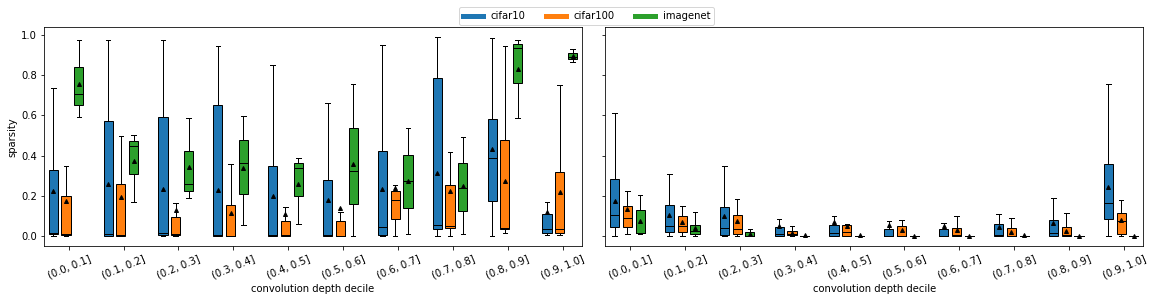

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4), facecolor="white", sharey=True, sharex=True)

boxplots(
    [
        get_sparsity_be_depth_decile(df_pairings[df_pairings.Normal.str.contains("_cifar10_")].Normal),
        get_sparsity_be_depth_decile(df_pairings[df_pairings.Normal.str.contains("_cifar100_")].Normal),
        get_sparsity_be_depth_decile(df_pairings[df_pairings.Normal.str.contains("_imagenet1k_")].Normal)
    ], labels=["cifar10", "cifar100", "imagenet"], ax=axes[0])

boxplots(
    [
        get_sparsity_be_depth_decile(df_pairings[df_pairings.Robust.str.contains("_cifar10_")].Robust),
        get_sparsity_be_depth_decile(df_pairings[df_pairings.Robust.str.contains("_cifar100_")].Robust),
        get_sparsity_be_depth_decile(df_pairings[df_pairings.Robust.str.contains("_imagenet_")].Robust)
    ], labels=["cifar10", "cifar100", "imagenet"], ax=axes[1])

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0,0.05,1,1), ncol=3)
fig.tight_layout()
axes[0].set_ylabel("sparsity")
plt.savefig("plots/sparsity_normal_vs_robust.pdf", bbox_inches='tight')